# Refraction Traveltime Tomography

### Author: M.Ravasi

This notebook runs a minimal example of Refraction Traveltime Tomography

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from scipy.signal import filtfilt
from scipy.sparse.linalg import lsqr
from pylops.basicoperators import *
from pylops.optimization.leastsquares import *

from refrtomo.gaussnewton import gauss_newton
from refrtomo.invert import *
from refrtomo.survey import *

## Velocity model and geometry

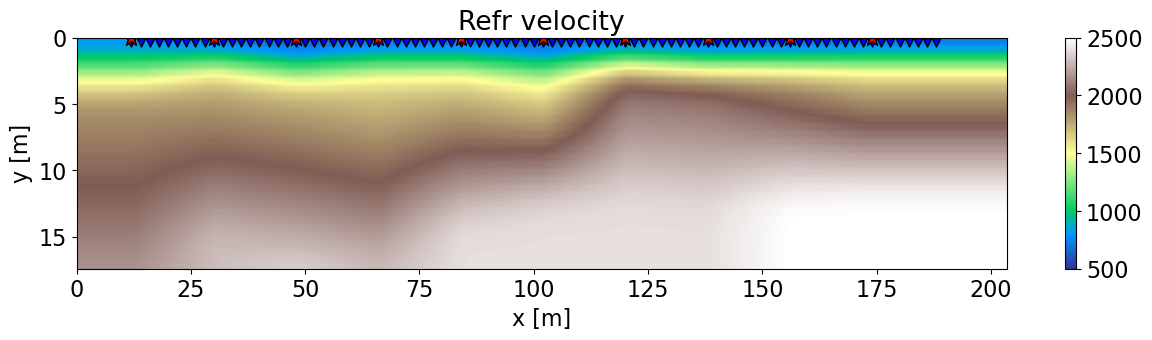

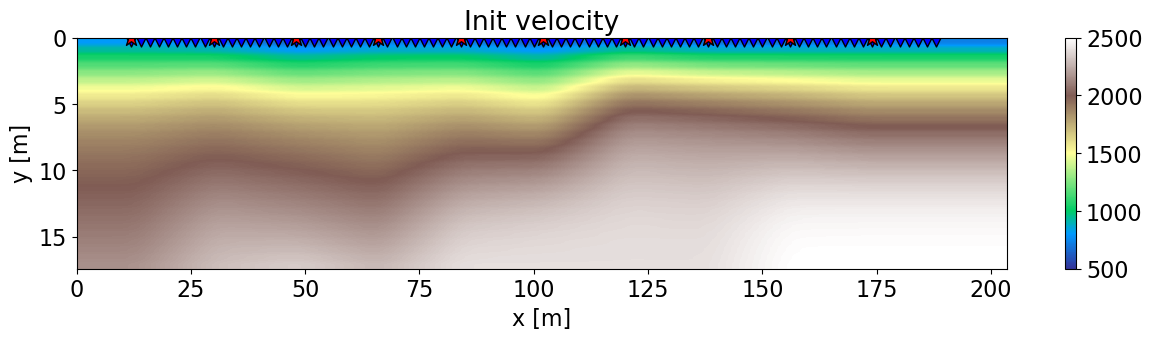

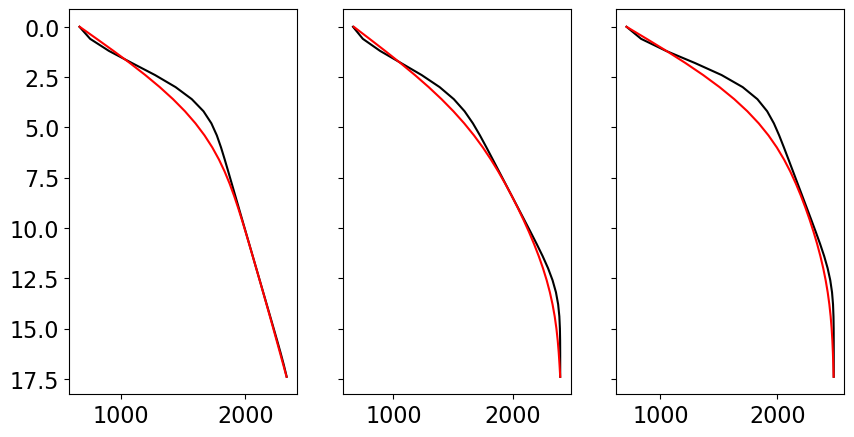

In [2]:
# Velocity model
fvel = np.load('../data/VelRefractionStryde.npz')
ftrav =  np.load('../data/FirstArrivalTravStryde.npz')

sc = 10. # from m to dm
x, z = fvel['x'] * sc, fvel['z'][:30] * sc
nx, nz = x.size, z.size
dx, dz = x[1]-x[0], z[1]-z[0]
vel_refr = fvel['vel'][:, :30] * sc
tobs = ftrav['tfirst']

# Pad model to last receiver
nxpad = (20, 50)
nx = nx + np.sum(nxpad)
x = np.arange(nx) * dx
vel_refr = np.pad(vel_refr, (nxpad, (0, 0)), mode='edge')

# Initial velocity
nsmooth = 5
vel_init = vel_refr.copy()
for _ in range(4):
    vel_init = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_init, axis=1)
    vel_init = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_init, axis=0)
#vel_init = np.tile(700 + 11. * z, (nx, 1)) * sc

# Receivers
rx = ftrav['xr'] * sc + nxpad[0] * dx
nr = rx.size
rz = 0*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# Sources
sx = ftrav['xs'] * sc + nxpad[0] * dx
ns = sx.size
sz = 0*np.ones(ns)
sources = np.vstack((sx, sz))
ds = sources[0,1]-sources[0,0]

#Raytraining parameters
lmax = 2e3
nl = 2000
thetas = np.hstack([np.arange(-89, -20, 0.1), np.arange(20, 89, 0.1)])

plt.figure(figsize=(15,3))
im = plt.imshow(vel_refr.T / sc, cmap='terrain', vmin=500, vmax=2500, 
                extent=(x[0] / sc, x[-1] / sc, z[-1] / sc, z[0] / sc))
plt.scatter(recs[0] / sc, recs[1] / sc, marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0] / sc, sources[1] / sc, marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Refr velocity')
plt.ylim(z[-1] / sc, z[0] / sc);

plt.figure(figsize=(15,3))
im = plt.imshow(vel_init.T / sc, cmap='terrain', vmin=500, vmax=2500, 
                extent=(x[0] / sc, x[-1] / sc, z[-1] / sc, z[0] / sc))
plt.scatter(recs[0] / sc, recs[1] / sc, marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0] / sc, sources[1] / sc, marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Init velocity')
plt.ylim(z[-1] / sc, z[0] / sc);

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10,5))
for ax, ix in zip(axs, [nx//4, nx//2, 3*nx//4]):
    ax.plot(vel_refr[ix] / sc, z / sc, 'k')
    ax.plot(vel_init[ix] / sc, z / sc, 'r')
axs[-1].invert_yaxis()

## Survey geometry

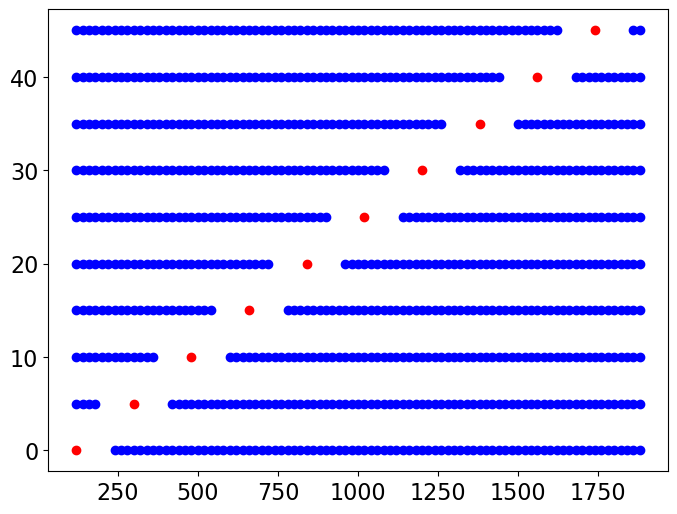

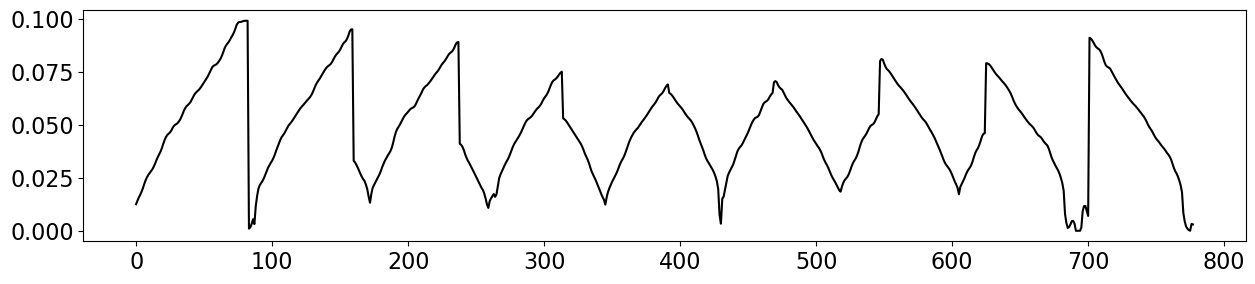

In [3]:
srcs = np.vstack((sx, sz))
recs = np.vstack((rx, rz))

survey = survey_geom(srcs, recs, minoffset=10 * sc)
avasurvey = survey_geom_observed(srcs, recs, tobs, minoffset=10 * sc)
tobs = extract_tobs(avasurvey)

display_survey(survey)

plt.figure(figsize=(15, 3))
plt.plot(tobs, 'k');

## Invert

Iteration 1/10
RefrTomo-fun: Computing...
survey_raytrace: 785 Source-receiver pairs in survey, 26 Source-receiver paired with ray...
match_surveys: 778 Rays in survey1, 26 Rays in survey2, 25 Matched rays...
tomographic_matrix: 25 rows, 10200 columns
RefrTomo-fun: Misfit 0.0013
RefrTomo-fun: Elapsed time 16.793136835098267 s...
Iteration 2/10
RefrTomo-fun: Computing...
survey_raytrace: 785 Source-receiver pairs in survey, 26 Source-receiver paired with ray...
match_surveys: 778 Rays in survey1, 26 Rays in survey2, 23 Matched rays...
tomographic_matrix: 23 rows, 10200 columns
RefrTomo-fun: Misfit 0.0011
RefrTomo-fun: Elapsed time 16.610569953918457 s...
Iteration 3/10
RefrTomo-fun: Computing...
survey_raytrace: 785 Source-receiver pairs in survey, 20 Source-receiver paired with ray...
match_surveys: 778 Rays in survey1, 20 Rays in survey2, 19 Matched rays...
tomographic_matrix: 19 rows, 10200 columns
RefrTomo-fun: Misfit 0.0017
RefrTomo-fun: Elapsed time 16.41470694541931 s...
Iteratio

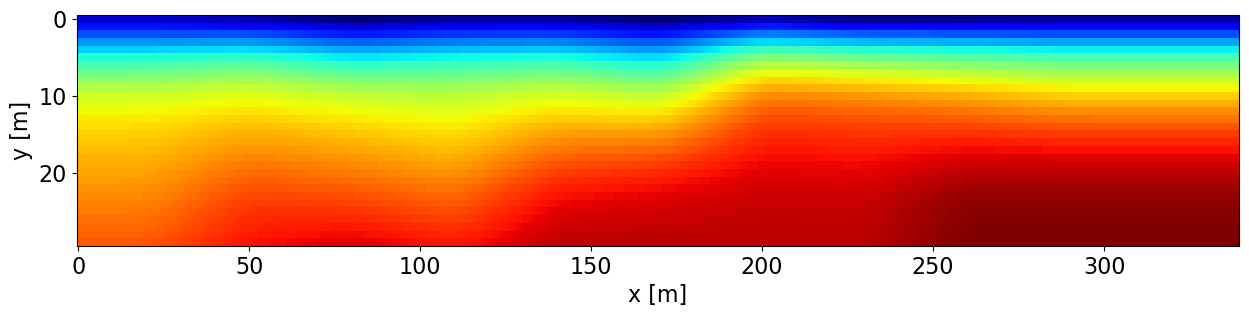

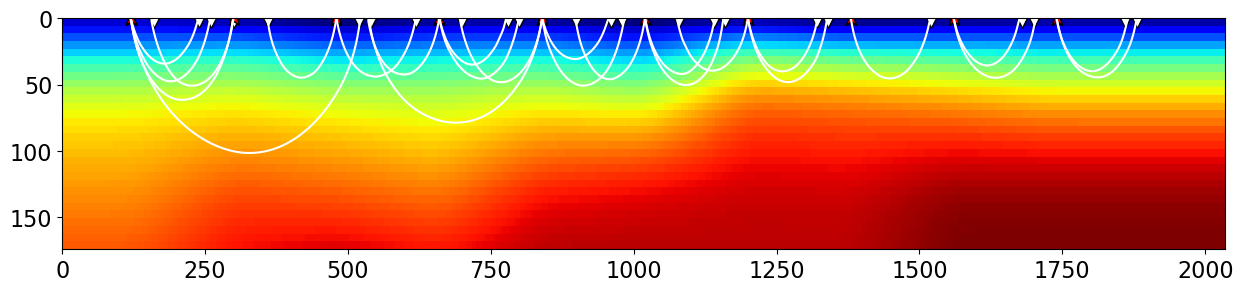

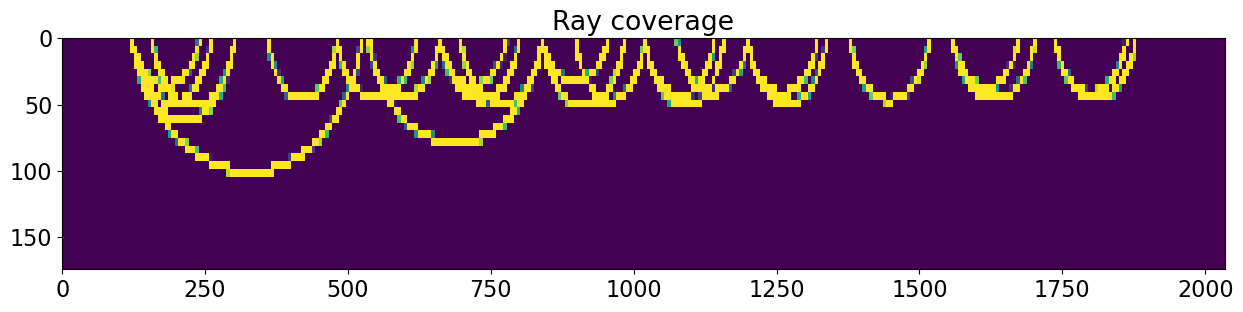

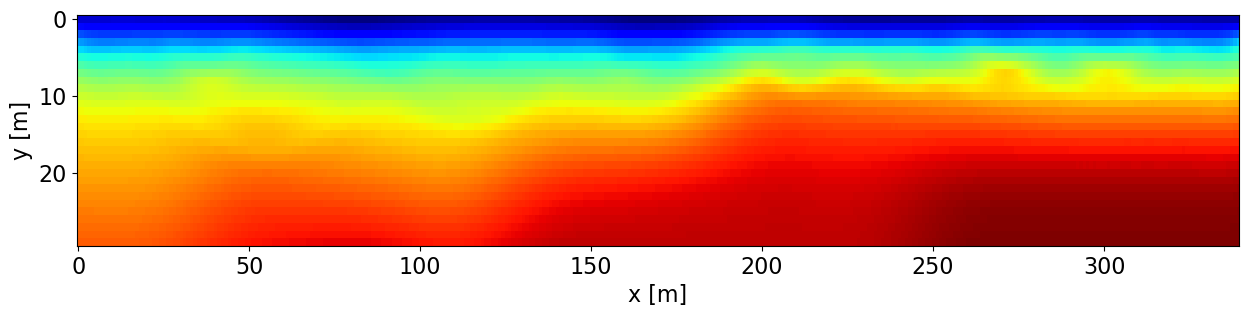

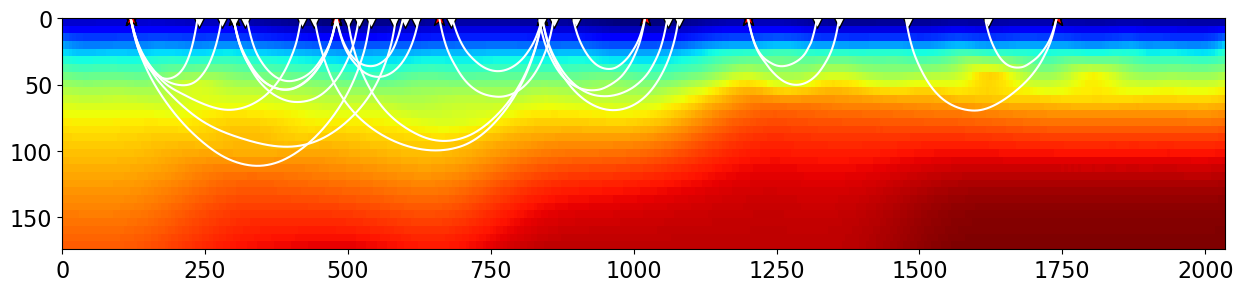

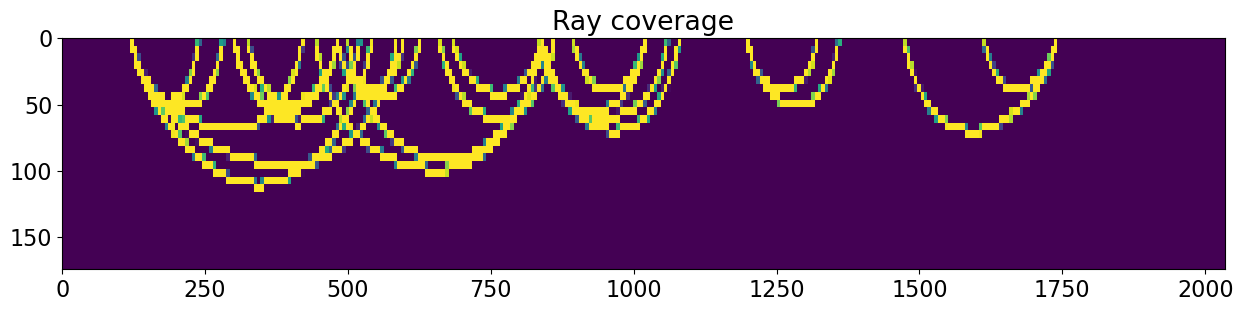

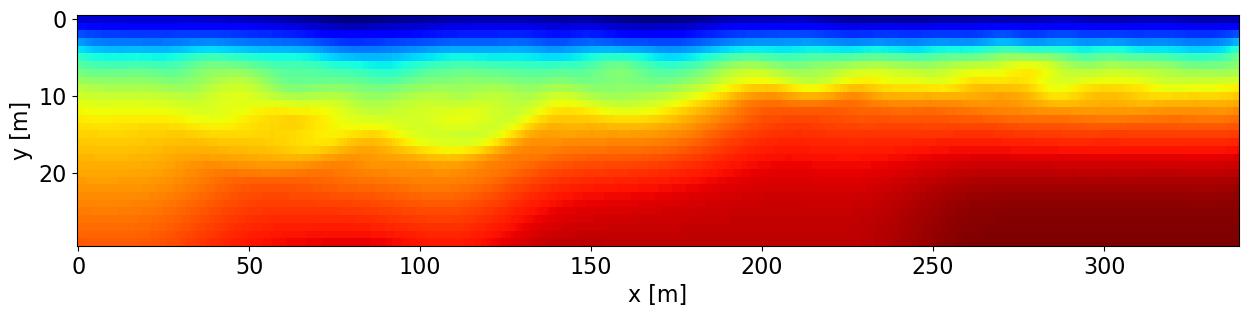

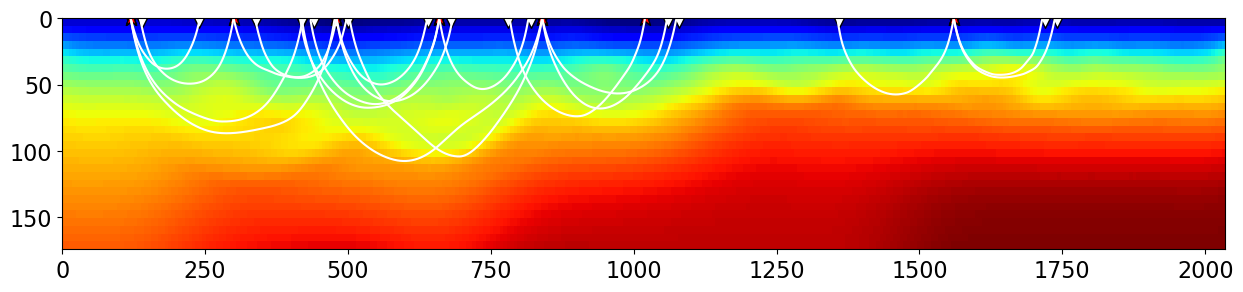

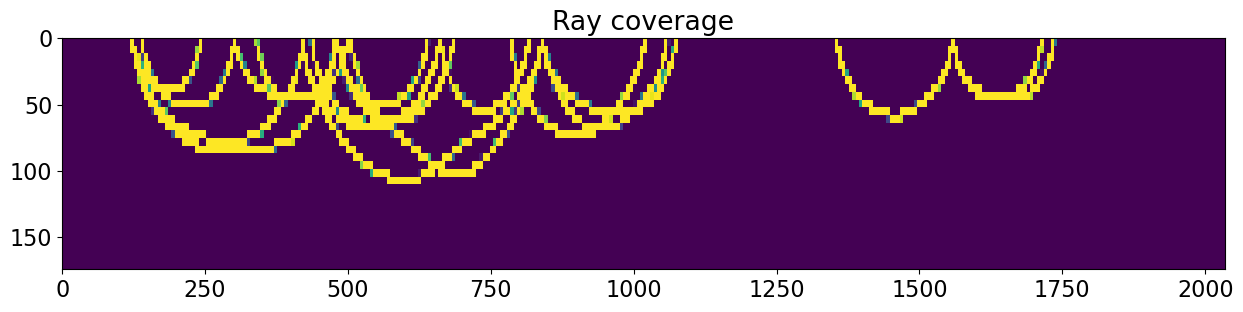

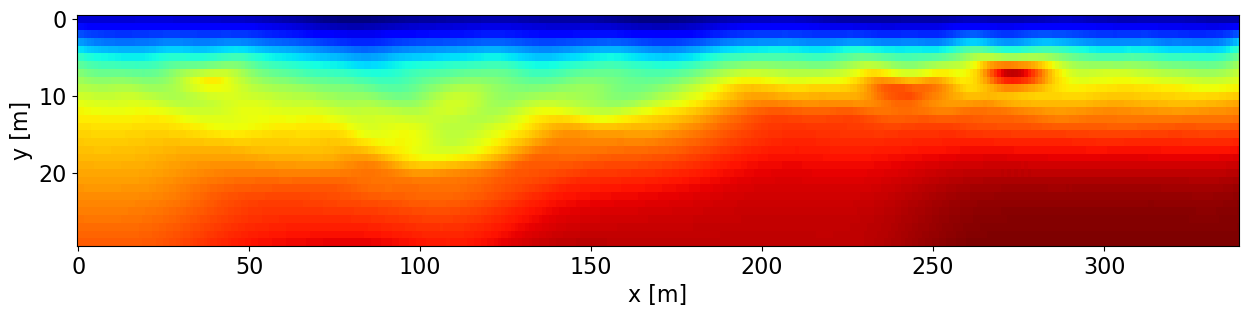

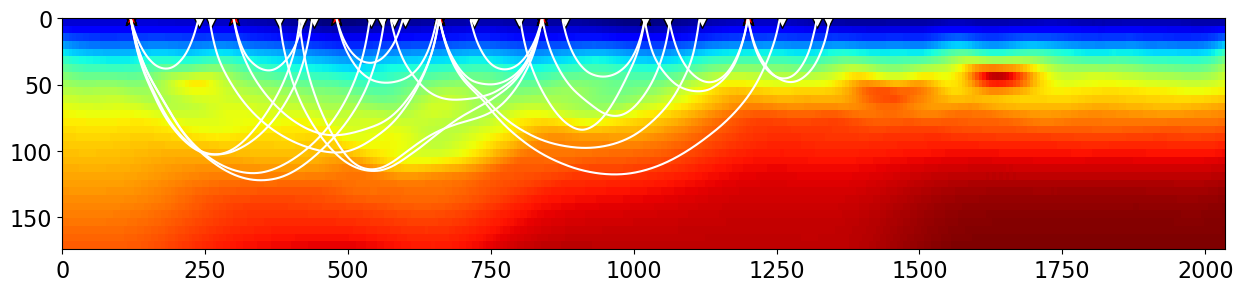

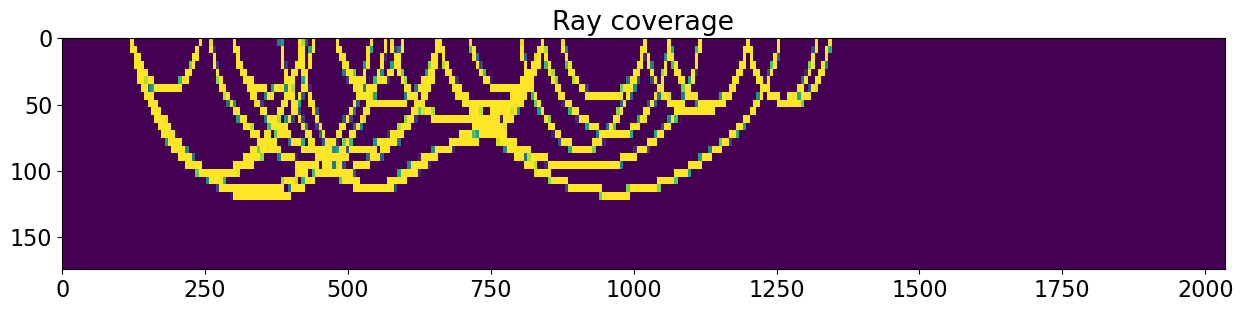

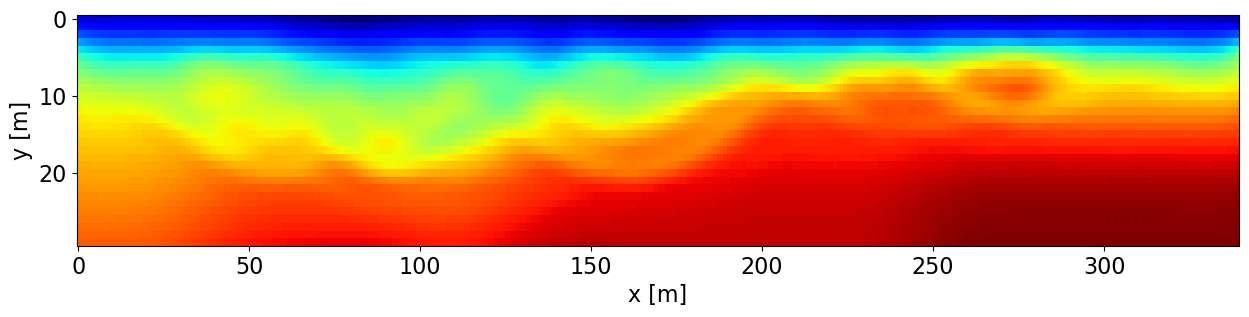

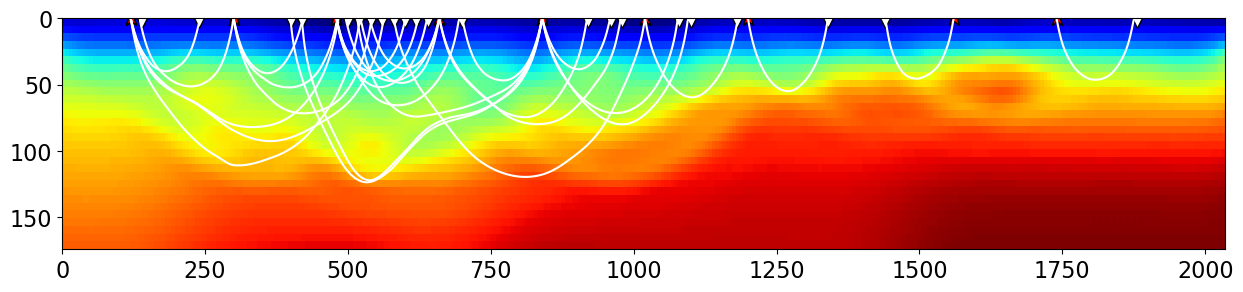

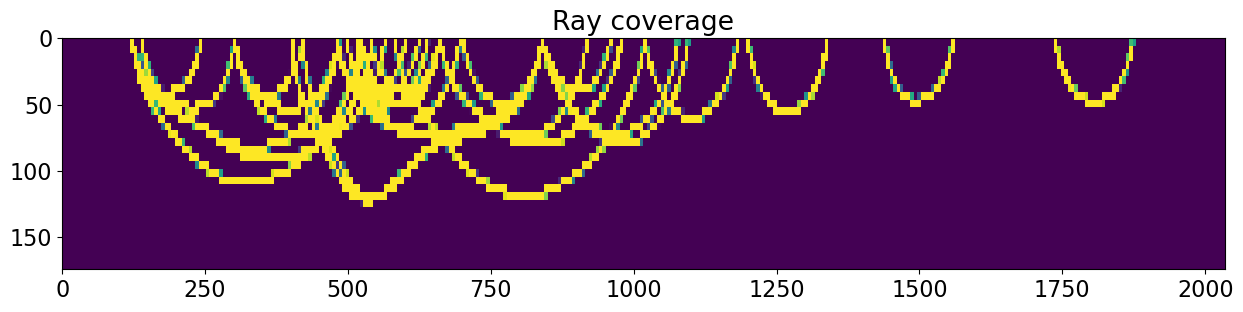

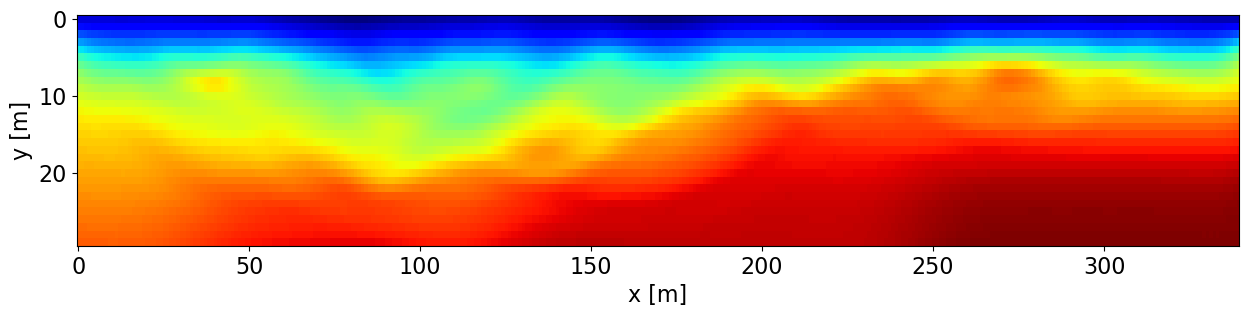

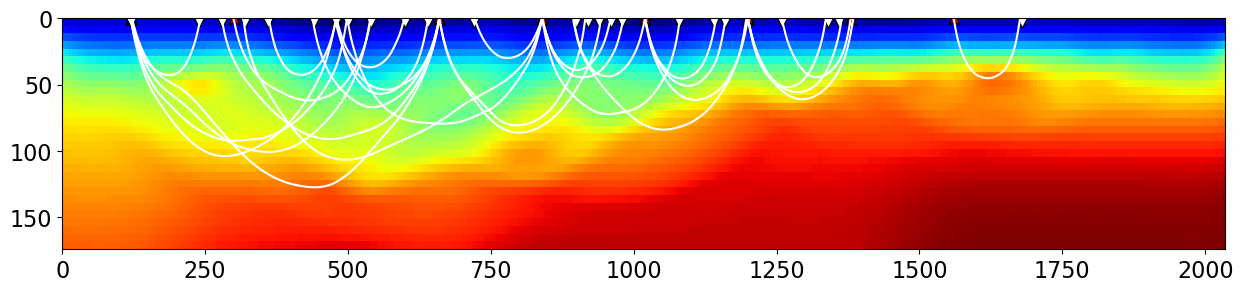

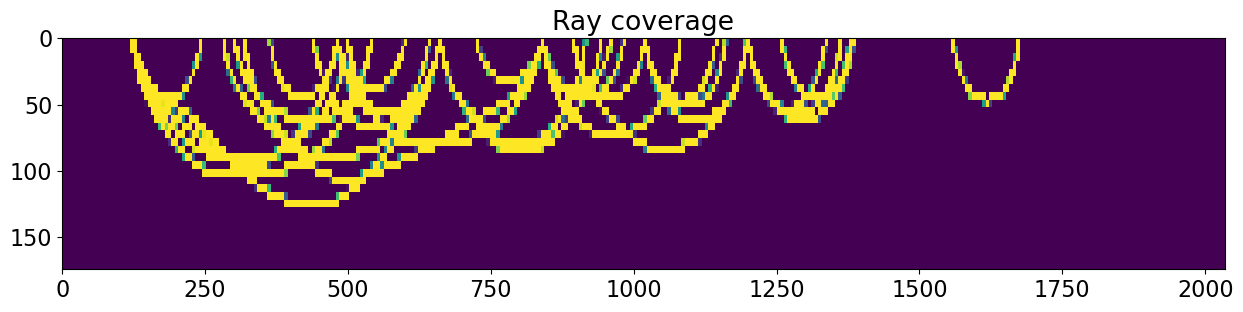

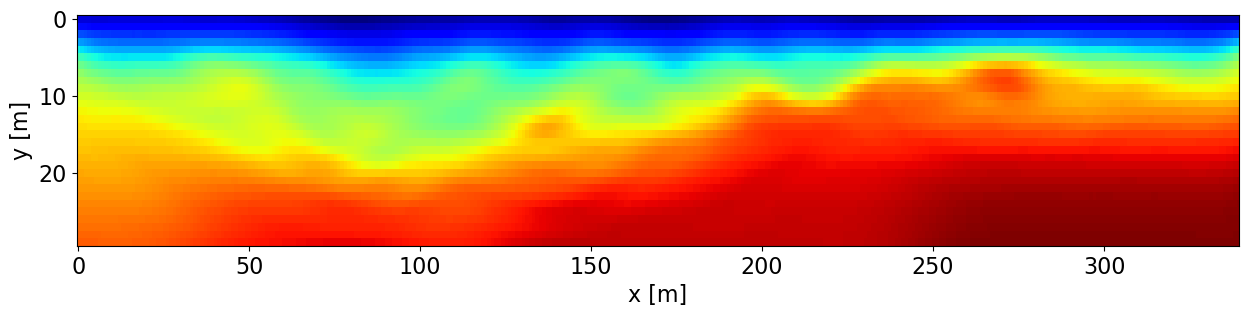

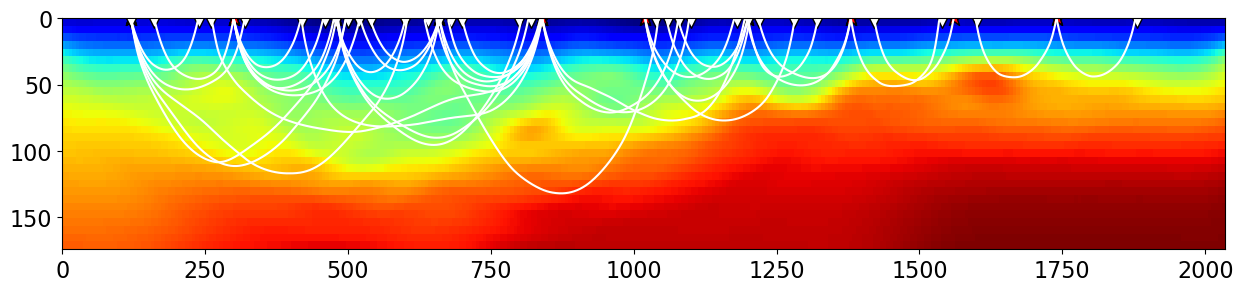

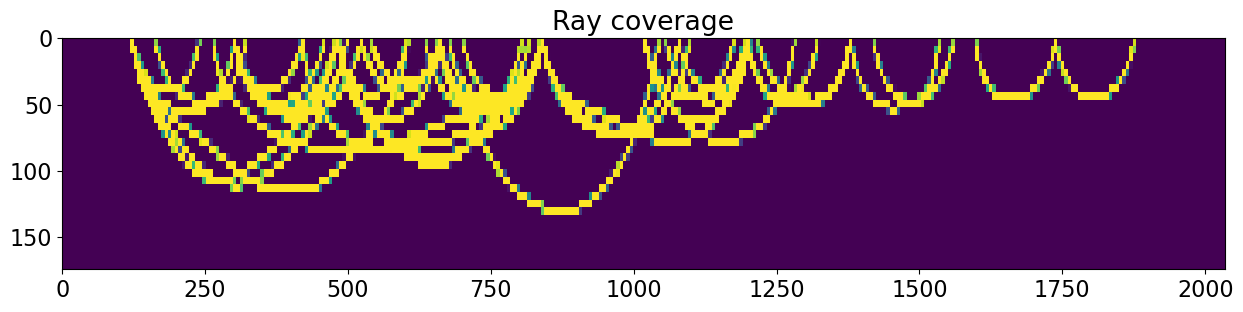

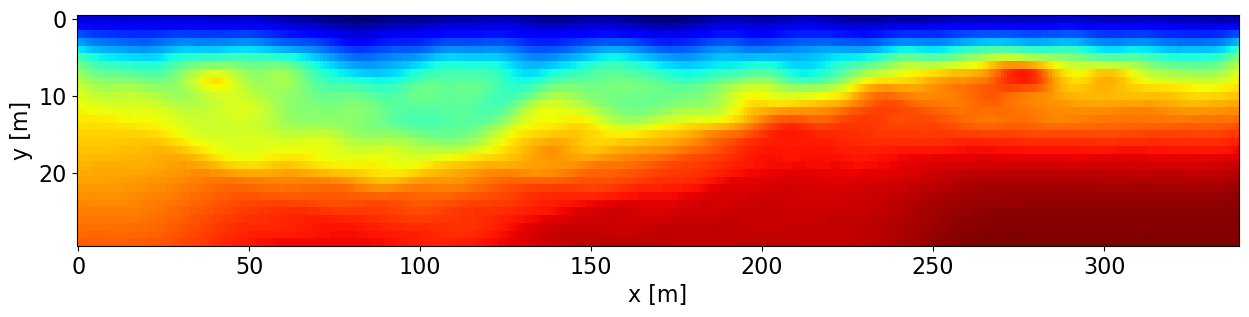

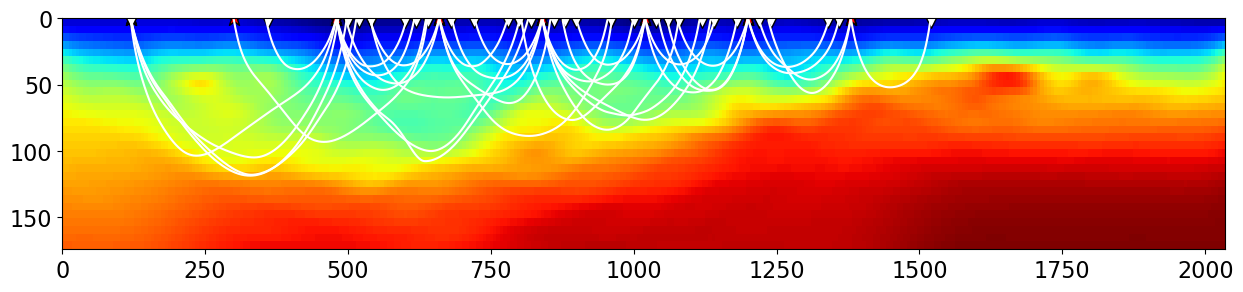

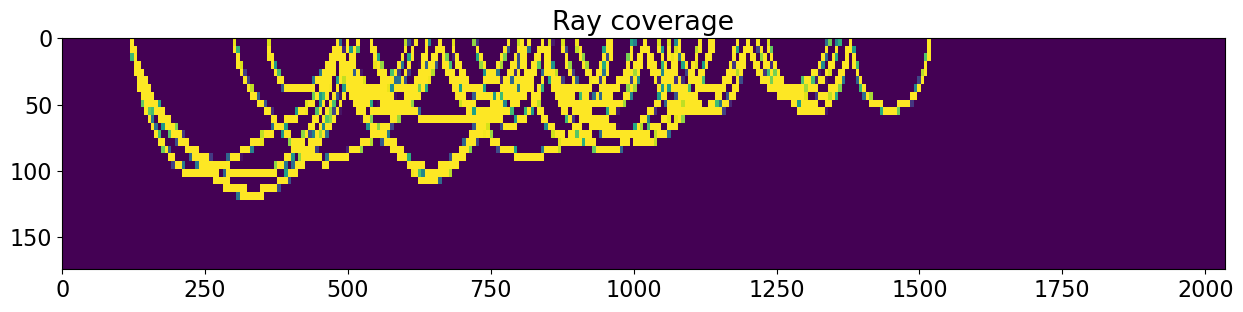

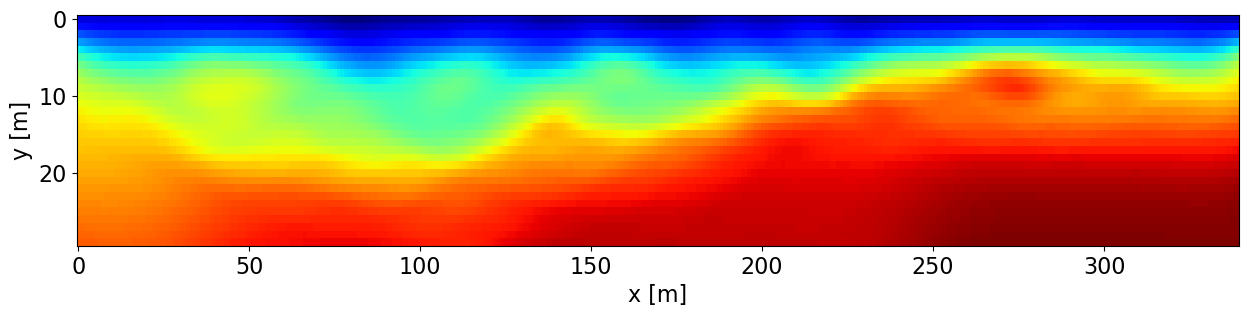

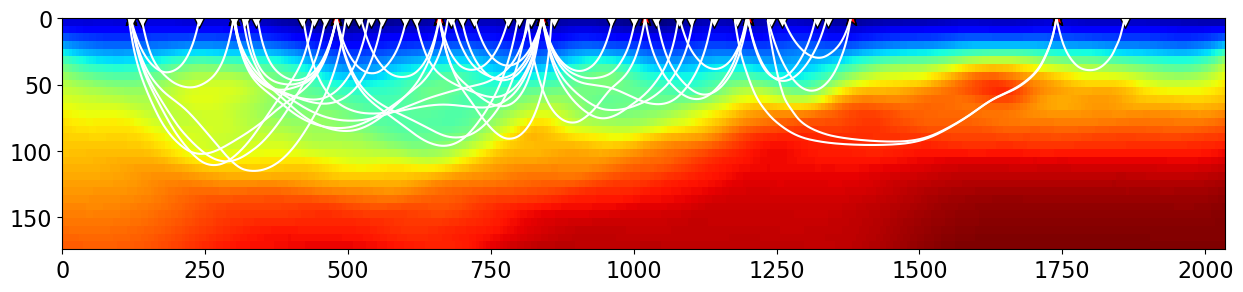

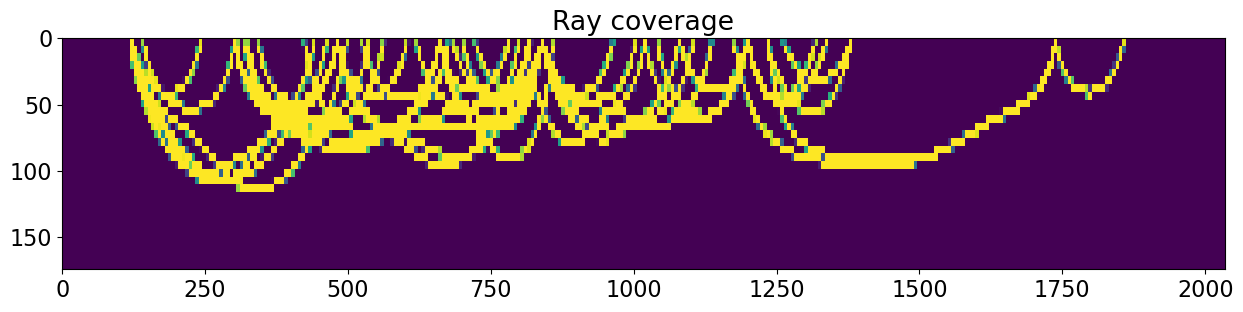

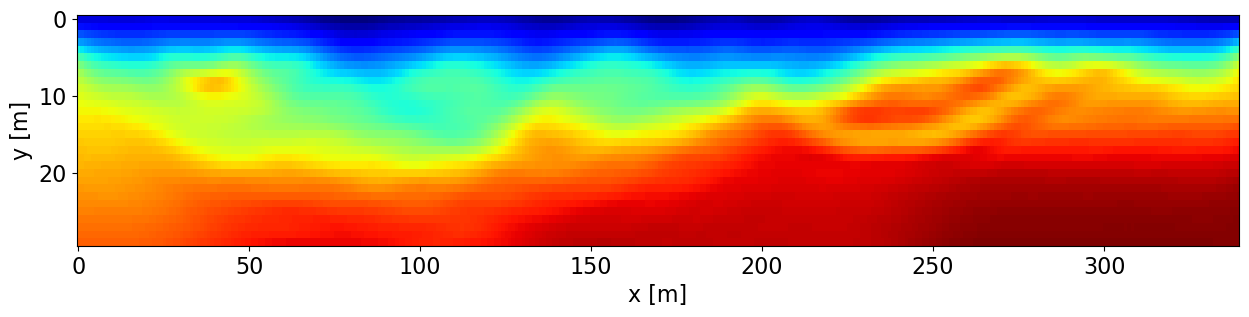

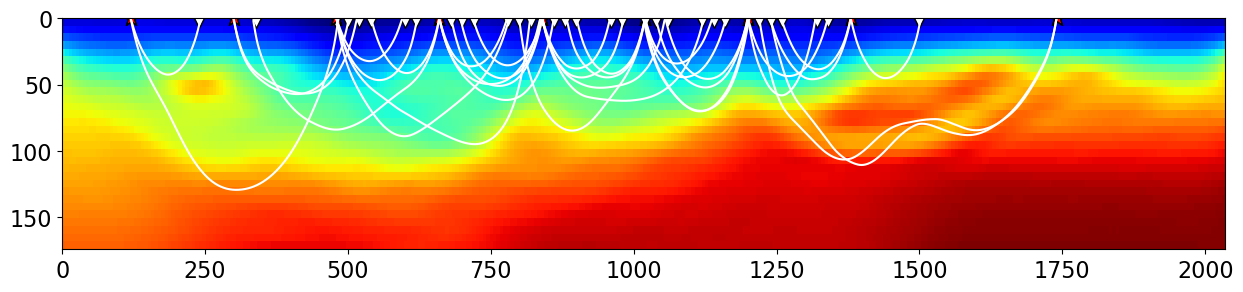

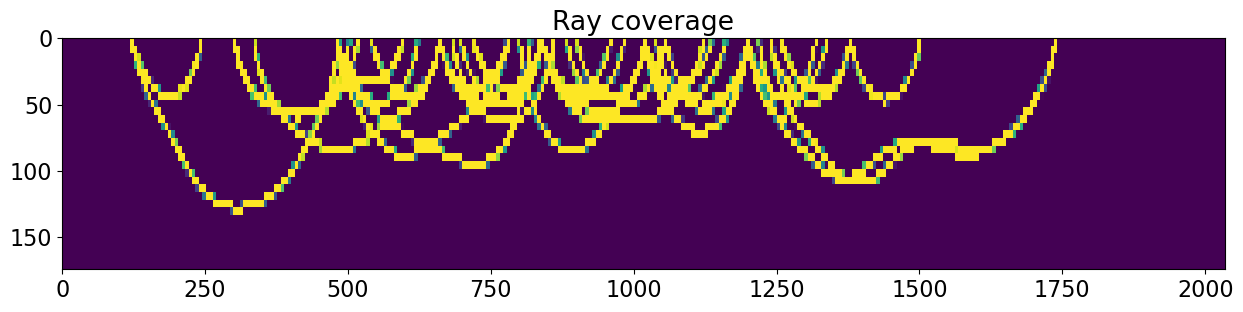

In [4]:
RTomo = RefrTomo(survey, avasurvey, x, z, lmax, nl, thetas, dzout=5., 
                 ray_rec_mindistance=5., epsL=1e2, weightsL=(10, 1), 
                 returnJ=True, debug=True)
vel_inv, misfit = RTomo.solve(vel_init.copy(), 10, lsqr_args=dict(iter_lim=40, damp=1e-1, show=False))

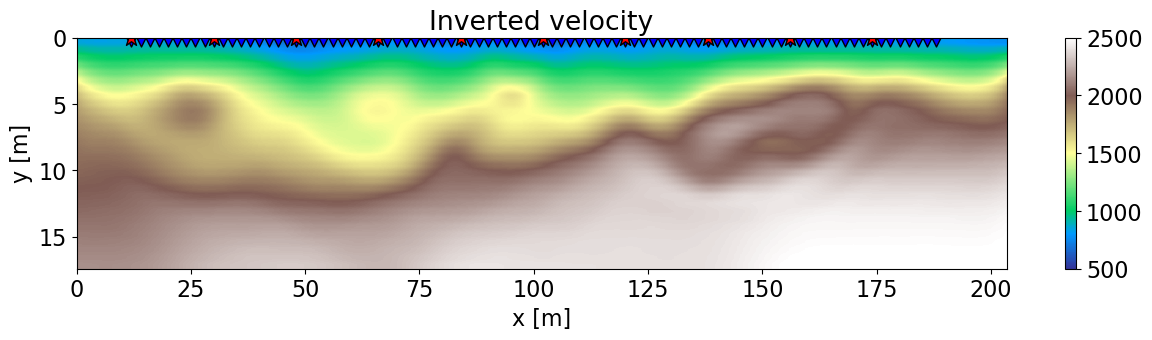

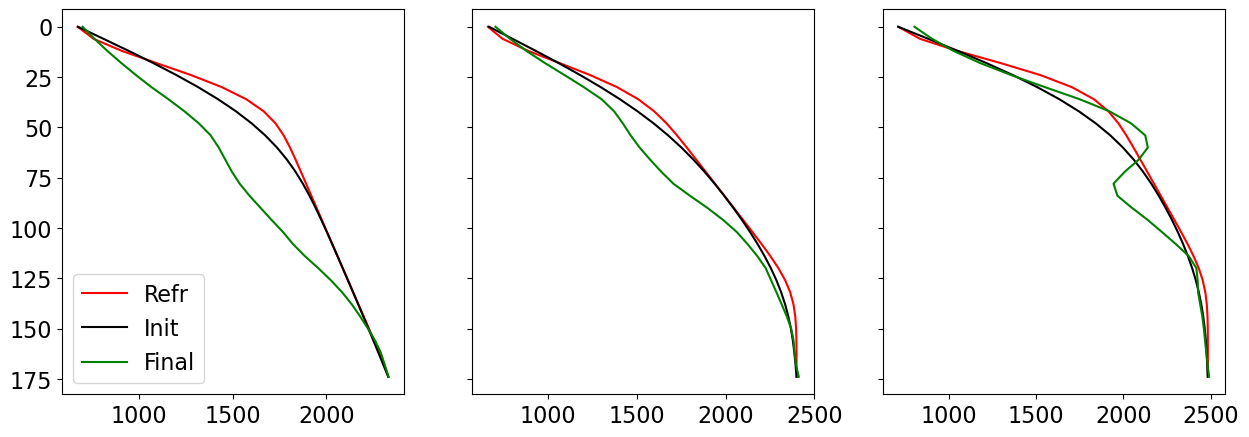

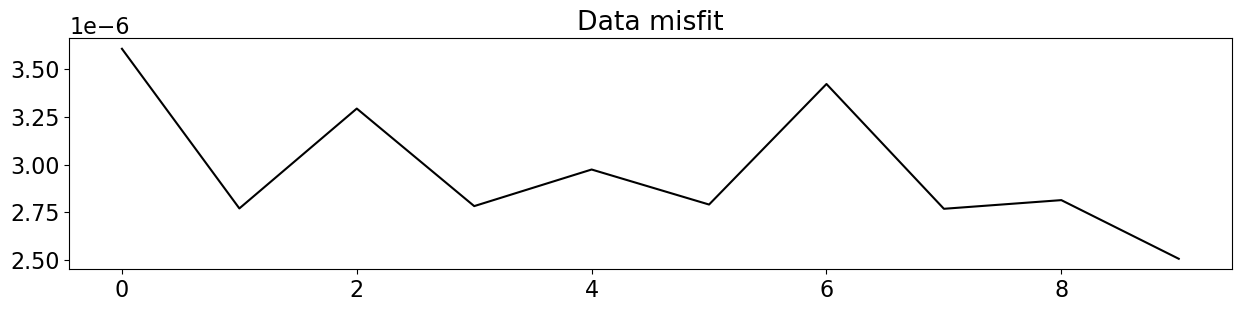

In [6]:
plt.figure(figsize=(15, 3))
im = plt.imshow(vel_inv.T / sc, cmap='terrain', vmin=500, vmax=2500, 
                extent=(x[0] / sc, x[-1] / sc, z[-1] / sc, z[0] / sc))
plt.scatter(recs[0] / sc, recs[1] / sc, marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0] / sc, sources[1] / sc, marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Inverted velocity')
plt.ylim(z[-1] / sc, z[0] / sc)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
for ax, ix in zip(axs, [nx//4, nx//2, 3*nx//4]):
    ax.plot(vel_refr[ix] / sc, z, 'r', label='Refr')
    ax.plot(vel_init[ix] / sc, z, 'k', label='Init')
    ax.plot(vel_inv[ix] / sc, z, 'g', label='Final')
    if ix == nx // 4:
        ax.legend()
axs[-1].invert_yaxis()

plt.figure(figsize=(15, 3))
plt.plot(misfit, 'k')
plt.title('Data misfit');